In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn import metrics
from tqdm import tqdm

data_dir = os.path.join("/export", "gaon1", "data", "jteneggi", "data", "synthetic")
truth_data_dir = os.path.join(data_dir, "LOR", "ground_truth")

exp_mapper = ["hexp/relative_70", "partexp", "gradexp", "deepexp", "lime"]

c = [1]
true_positives = np.load("true_positives.npy", allow_pickle=True).item()

exp_df_clips = []
for j, n in enumerate(c):
    for exp_name in tqdm(exp_mapper):
        exp_df_path = os.path.join("true_positive_explanations", exp_name, f"f1_scores_{n}.csv")
        
        if os.path.exists(exp_df_path):
            exp_df = pd.read_csv(exp_df_path)
        else:
            exp_df = pd.DataFrame(columns=["n", "exp_name", "f1", "comp_time"])
            
            exp_comp_times_path = os.path.join("true_positive_explanations", exp_name, f"comp_times_{n}.npy")
            exp_comp_times = np.load(exp_comp_times_path)
        # if "hexp" in exp_name:
        #      mode_name = exp_name.split("/")[1]
        #      exp_comp_times = comp_times["hexp"][mode_name]
        #  else:
        #      exp_comp_times = comp_times[exp_name]
            explanation_dir = os.path.join("true_positive_explanations", exp_name)
            scores = []
            for i, image_path in enumerate(true_positives[str(n)]):
                image = Image.open(image_path)
                image_name = os.path.basename(image_path)
                image_id = int(image_name.split("_")[1].split(".")[0])
                # print(image_name, image_id)
                ground_truth = np.zeros((100, 120))
                positions = np.load(os.path.join(truth_data_dir, str(n), f"ex{n}_{image_id}.npy"))
                # print(positions)
                for position in positions:
                    top_left = position[0]
                    bottom_right = position[1]
                    for k in range(9):
                        ground_truth[top_left[1]+k, top_left[0]+k] = 1
                        ground_truth[bottom_right[1]-k, top_left[0]+k] = 1
                    # ground_truth[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1] = 1
                # axes[0].imshow(ground_truth)
                explanation = np.load(os.path.join(explanation_dir, f"{image_name}.npy"))
                score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 0)
                # print(exp_name, score, exp_comp_times[i])
                if exp_comp_times[i] > 0 and score > 0:
                    exp_df = exp_df.append({"n": n, "exp_name": exp_name, "f1": score, "comp_time": exp_comp_times[i]}, ignore_index=True)
            exp_df.to_csv(exp_df_path)
        exp_df_clips.append(exp_df)
df = pd.concat(exp_df_clips, axis=0)

100%|██████████| 5/5 [00:00<00:00, 101.53it/s]


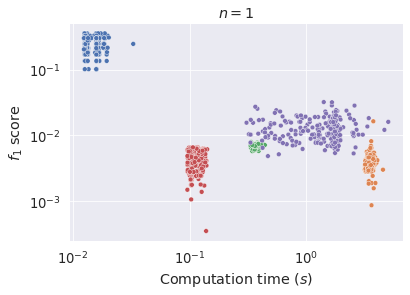

In [2]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5)

g = sns.scatterplot(data=df, x="comp_time", y="f1", hue="exp_name", legend=False)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Computation time ($s$)")
plt.ylabel(r"$f_1$ score")
plt.title(r"$n=1$")
plt.savefig("f1_time_seaborn.eps")
plt.savefig("f1_time_seaborn.jpg")
plt.savefig("f1_time_seaborn.pdf")

# g = sns.FacetGrid(df, hue="exp_name", col="n", height=4)
# g.map(sns.scatterplot, "comp_time", "f1", legend=True)
# g.set(xscale="log", yscale="log", xlim=[5e-3, 1e1])
# g.set_axis_labels(r"Computation time ($s$)", r"$f_1$ score")
# replace labels
# new_labels = [r"$b$H-SHAP", r"GradientExplainer", r"DeepExplainer", r"PartitionExplainer", r"LIME"]
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# plt.legend(loc=3)

plt.savefig("f1_time_seaborn.eps")
plt.savefig("f1_time_seaborn.jpg")
plt.savefig("f1_time_seaborn.pdf")